# 0. Attaching libraries

In [1]:
import os
import sqlite3
import pandas as pd
import sys
#from ydata_profiling import ProfileReport # for profiling
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
sns.set_style("whitegrid")       # optional aesthetics
%matplotlib inline 

In [2]:
from dateutil.relativedelta import relativedelta
import builtins

In [167]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning, module="sklearn")

# 1. Reading the core Dataset from the golden source

In [3]:
data_path = r"C:\Users\dimet\OneDrive - NOVAIMS\NOVA IMS BDMWDS\0 Data"
csv_name  = "Dataset.csv"
csv_file  = os.path.join(data_path, csv_name)
excel_path  = (r"C:\Users\dimet\OneDrive - NOVAIMS\NOVA IMS BDMWDS"
               r"\3 Databook\Source_data_Conversion.xlsx")
# ── Load the CSV into a DataFrame ──────────────────────────────────────────
df = pd.read_csv(csv_file, low_memory=False)

In [4]:
# Quick sanity check (optional)
print(df.shape)       # prints (rows, columns)

(9373, 78)


## NEW COLUMNS

In [5]:
df["customer_id"] = df[["zipcode_link", "zip4", "place_residence","birth_date", "gender"]].astype(str).agg("-".join, axis=1)

In [6]:
# 1. Build boolean conditions based on == "Y"
conditions = [
    df['wa'] == 'Y',
    df['wa_bep_ca'] == 'Y',
    df['wa_ca'] == 'Y'
]

# 2. Corresponding labels
choices = ['1. Only liability insurance', '2. Liability + limited casco', '3. Liability + full casco']

# 3. Create the new column, defaulting to NaN if none of the three has "Y"
df['coverage_type'] = np.select(conditions, choices, default=np.nan)

In [7]:
# ── 1. External “today” reference ───────────────────────────────────────────
current_date = pd.to_datetime("2019-11-01")    # ← use any value you like
fancy_date = current_date.strftime("%B %d %Y")

In [8]:
# ── 2. Parse birth_date & compute age ───────────────────────────────────────
# 2-a. Ensure birth_date is a datetime column
df["birth_date"] = pd.to_datetime(df["birth_date"], errors="coerce")

# 2-b. Convert to integer years using dateutil.relativedelta for accuracy
df["age"] = df["birth_date"].apply(
    lambda bd: relativedelta(current_date, bd).years if pd.notnull(bd) else pd.NA
)
# ── 1. Ensure age is numeric ────────────────────────────────────────────────
# (errors='coerce' converts any bad strings to NaN so they drop out later)
df["age"] = pd.to_numeric(df["age"], errors="coerce")

# ── 2. Create age bands ─────────────────────────────────────────────────────
age_bins   = [0, 25, 35, 45, 55, 65, 120]               # tweak if needed
age_labels = ["<25", "25–34", "35–44", "45–54", "55–64", "65+"]

In [9]:
df["age_band"] = pd.cut(df["age"],
                           bins=age_bins,
                           labels=age_labels,
                           right=False)

In [10]:
df["urb_norm"] = (
    df["URB"]
      .astype(str)
      .str.strip()
      .str[0]                    # first letter
      .str.upper()
      .replace({"1": "1-VeryHigh", "2": "2-High", "3": "3-Mid-to-High", "4": "4-Mid", "5": "5-Mid-to-Low", "6": "6-Low","7": "7-VeryLow", "0": "Unknown", "N" : "Unknown"})
)

In [11]:
month_map = {
    "January":   "01",
    "February":  "02",
    "March":     "03",
    "April":     "04",
    "May":       "05",
    "June":      "06",
    "July":      "07",
    "August":    "08",
    "September": "09",
    "October":   "10",
    "November":  "11",
    "December":  "12"
}

df["buildmonth_num"] = df["buildmonth_car"].map(month_map)

In [12]:
# 2. Combine year + month + “01” (first of month) into a YYYY-MM-DD string and convert to datetime:
df["build_date"] = pd.to_datetime(
    df["buildyear_car"].astype(str).str[:4] + "-" + 
    df["buildmonth_num"] + "-01"
)

# Now 'build_date' holds a Timestamp for the first day of that month/year.
print(df[["buildyear_car", "buildmonth_car", "build_date"]].head())

   buildyear_car buildmonth_car build_date
0         2016.0           June 2016-06-01
1         2015.0           June 2015-06-01
2         2016.0          April 2016-04-01
3         2009.0           June 2009-06-01
4         2003.0        January 2003-01-01


In [13]:
# Calculate car_age
df['car_age'] = current_date.year - df['build_date'].dt.year - (
    (current_date.month < df['build_date'].dt.month) |
    ((current_date.month == df['build_date'].dt.month) & (current_date.day < df['build_date'].dt.day))
).astype(int)

In [14]:
# 1) Make sure `policy_start_date` is a datetime:
df['policy_start_date'] = pd.to_datetime(
    df['policy_start_date'],
    errors='coerce'
)

In [15]:
# Define age bins and labels
bins = [0, 3, 7, 11, 100]
labels = ['0-3', '4-7', '8-11', '12+']

# Create normalized age categories
df['car_age_norm'] = pd.cut(df['car_age'], bins=bins, labels=labels, include_lowest=True).cat.add_categories('Unknown').fillna("Unknown")


In [16]:
df

,affinity_name,status_report,offer_number,policy_number,zipcode_link,zip4,birth_date,brand,date_offer,date_request,...,churn,customer_id,coverage_type,age,age_band,urb_norm,buildmonth_num,build_date,car_age,car_age_norm
0,Insuro,Requestwithdrawn,1000,10000.0,10000,2132,1985-01-01,HYUNDAI,2018-10-11,2018-10-11,...,1,10000-2132-nan-1985-01-01-nan,1. Only liability insurance,34.0,25–34,3-Mid-to-High,06,2016-06-01,3.0,0-3
1,other,Tailoredofferwithdrawn,1001,NaN,10001,6027,1987-04-01,AUDI,2018-10-11,NaN,...,-1,10001-6027-nan-1987-04-01-nan,nan,32.0,25–34,7-VeryLow,06,2015-06-01,4.0,4-7
2,other,Incompleterequest,1002,NaN,10002,3824,1972-11-01,VOLKSWAGEN,2018-10-11,NaN,...,-1,10002-3824-nan-1972-11-01-nan,3. Liability + full casco,47.0,45–54,2-High,04,2016-04-01,3.0,0-3
3,other,Policycreated,1003,10002.0,10003,6921,1983-08-01,MAZDA,2018-10-11,2018-10-11,...,1,10003-6921-nan-1983-08-01-nan,2. Liability + limited casco,36.0,35–44,4-Mid,06,2009-06-01,10.0,8-11
4,other,Policycreated,1004,10003.0,10004,8266,1990-04-01,VOLVO,2018-10-12,2018-10-12,...,1,10004-8266-nan-1990-04-01-nan,1. Only liability insurance,29.0,25–34,4-Mid,01,2003-01-01,16.0,12+
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9368,other,Requestaccepted,9439,11946.0,15568,1161,1960-09-01,VOLKSWAGEN,2020-03-08,2020-03-08,...,-1,15568-1161-nan-1960-09-01-nan,3. Liability + full casco,59.0,55–64,6-Low,12,2011-12-01,7.0,4-7
9369,other,Waitforapproval,9440,11947.0,15582,5015,1953-04-01,NISSAN,2020-03-08,2020-03-08,...,-1,15582-5015-nan-1953-04-01-nan,3. Liability + full casco,66.0,65+,2-High,02,2017-02-01,2.0,0-3
9370,Insuro,Tailoredofferrequested,9441,NaN,10332,3078,1976-04-01,TOYOTA,2020-03-08,NaN,...,-1,10332-3078-nan-1976-04-01-nan,2. Liability + limited casco,43.0,35–44,1-VeryHigh,01,2004-01-01,15.0,12+
9371,T&B,Calculatenewpremium,9442,NaN,12968,1965,1951-07-01,TOYOTA,2020-03-08,NaN,...,-1,12968-1965-nan-1951-07-01-nan,2. Liability + limited casco,68.0,65+,4-Mid,09,2004-09-01,15.0,12+


## ANALYSIS

In [214]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

In [215]:
columns_to_keep = [
       "zip4", "PROVINCE", 'URB', 'INCOME', 'SOCCL_A', 'SOCCL_B1', 'SOCCL_B2', 'SOCCL_C',
       'SOCCL_D', 'EDU_HIGH', 'EDU_MID', 'EDU_LOW', 'DINK', 'OWN_HOUSE',
       'AVG_HOUSE', 'STAGE_OF_LIFE', 'SINGLE', 'FAM',
       'FAM_WCHILD', 'SINGLES_YOUNG', 'SINGLES_MID', 'SINGLES_OLD',
       'FAM_CHILD_Y', 'FAM_CHILD_O', 'FAM_WCHILD_Y', 'FAM_WCHILD_MED',
       'FAM_WCHILD_OLD', 'CIT_HOUSEHOLD', 'LOAN', 'SAVINGS', 'SHOP_ONLINE','CAR',
    "conv","churn"
       ]

In [216]:
df_sub = df[df["affinity_name"]=="T&B"][columns_to_keep].copy()

In [217]:
df_sub.head()

,zip4,PROVINCE,URB,INCOME,SOCCL_A,SOCCL_B1,SOCCL_B2,SOCCL_C,SOCCL_D,EDU_HIGH,...,FAM_WCHILD_Y,FAM_WCHILD_MED,FAM_WCHILD_OLD,CIT_HOUSEHOLD,LOAN,SAVINGS,SHOP_ONLINE,CAR,conv,churn
787,7582,Overijssel,5.0,2.0,3.0,4.0,2.0,1.0,2.0,3.0,...,1.0,3.0,4.0,5.0,1.0,5.0,6.0,5.0,0,-1
873,3221,South Holland,4.0,6.0,1.0,3.0,3.0,1.0,1.0,1.0,...,1.0,2.0,4.0,4.0,2.0,5.0,3.0,3.0,0,-1
952,4634,North Brabant,7.0,2.0,4.0,3.0,2.0,2.0,1.0,4.0,...,1.0,1.0,3.0,5.0,1.0,4.0,6.0,5.0,1,0
953,4634,North Brabant,7.0,2.0,4.0,3.0,2.0,2.0,1.0,4.0,...,1.0,1.0,3.0,5.0,1.0,4.0,6.0,5.0,0,-1
954,4634,North Brabant,7.0,2.0,4.0,3.0,2.0,2.0,1.0,4.0,...,1.0,1.0,3.0,5.0,1.0,4.0,6.0,5.0,0,-1


In [218]:
print(df_sub.isna().sum())

zip4                0
PROVINCE           21
URB                21
INCOME            198
SOCCL_A            36
SOCCL_B1           36
SOCCL_B2           36
SOCCL_C            36
SOCCL_D            36
EDU_HIGH           36
EDU_MID            36
EDU_LOW            36
DINK               36
OWN_HOUSE          37
AVG_HOUSE          61
STAGE_OF_LIFE      45
SINGLE             36
FAM                36
FAM_WCHILD         36
SINGLES_YOUNG      36
SINGLES_MID        36
SINGLES_OLD        36
FAM_CHILD_Y        36
FAM_CHILD_O        36
FAM_WCHILD_Y       36
FAM_WCHILD_MED     36
FAM_WCHILD_OLD     36
CIT_HOUSEHOLD      36
LOAN               36
SAVINGS            36
SHOP_ONLINE        36
CAR                36
conv                0
churn               0
dtype: int64


In [219]:
mode_income = (
    df_sub
    .groupby('zip4')['INCOME']
    .agg(lambda x: x.mode().iloc[0] if not x.mode().empty else np.nan)
    .rename('mode_income')
)

# 2. Merge the mode back into the original DataFrame
df_sub = df_sub.merge(mode_income, left_on='zip4', right_index=True)

# 3. Impute missing INCOME values using the mode for that zip4
df_sub['INCOME_filled'] = df_sub['INCOME'].fillna(df_sub['mode_income'])

# 4. (Optional) Drop the helper column if you no longer need it
df_sub.drop(columns=['mode_income'], inplace=True)

In [220]:
# 2. Second imputation: For any remaining NaNs in INCOME, use PROVINCE-level mode
#    - Compute mode income per PROVINCE based on the “INCOME_imputed_zip4” column
mode_income_prov = (
    df_sub
    .groupby('PROVINCE')['INCOME_filled']
    .agg(lambda x: x.mode().iloc[0] if not x.mode().empty else np.nan)
    .rename('mode_income_prov')
)

# Merge and fill any remaining NaNs based on province mode
df_sub = df_sub.merge(mode_income_prov, left_on='PROVINCE', right_index=True)
df_sub['INCOME_final'] = df_sub['INCOME_filled'].fillna(df_sub['mode_income_prov'])

# Drop helper columns if desired
df_sub.drop(columns=["INCOME", 'INCOME_filled', 'mode_income_prov'], inplace=True)

In [221]:
df_sub.dropna(axis=0, how='any', inplace=True)

In [222]:
print(df_sub.isna().sum())

zip4              0
PROVINCE          0
URB               0
SOCCL_A           0
SOCCL_B1          0
SOCCL_B2          0
SOCCL_C           0
SOCCL_D           0
EDU_HIGH          0
EDU_MID           0
EDU_LOW           0
DINK              0
OWN_HOUSE         0
AVG_HOUSE         0
STAGE_OF_LIFE     0
SINGLE            0
FAM               0
FAM_WCHILD        0
SINGLES_YOUNG     0
SINGLES_MID       0
SINGLES_OLD       0
FAM_CHILD_Y       0
FAM_CHILD_O       0
FAM_WCHILD_Y      0
FAM_WCHILD_MED    0
FAM_WCHILD_OLD    0
CIT_HOUSEHOLD     0
LOAN              0
SAVINGS           0
SHOP_ONLINE       0
CAR               0
conv              0
churn             0
INCOME_final      0
dtype: int64


In [223]:
# (a) List categorical and numeric features explicitly:
cat_features = ['PROVINCE']

columns_to_keep_kmeans = [
       'PROVINCE','URB', 'INCOME_final', 'SOCCL_A', 'SOCCL_B1', 'SOCCL_B2', 'SOCCL_C',
       'SOCCL_D', 'EDU_HIGH', 'EDU_MID', 'EDU_LOW', 'DINK', 'OWN_HOUSE',
       'AVG_HOUSE', 'STAGE_OF_LIFE', 'SINGLE', 'FAM',
       'FAM_WCHILD', 'SINGLES_YOUNG', 'SINGLES_MID', 'SINGLES_OLD',
       'FAM_CHILD_Y', 'FAM_CHILD_O', 'FAM_WCHILD_Y', 'FAM_WCHILD_MED',
       'FAM_WCHILD_OLD', 'CIT_HOUSEHOLD', 'LOAN', 'SAVINGS', 'SHOP_ONLINE','CAR',
    "conv","churn"
       ]

num_features = [col for col in columns_to_keep_kmeans if col not in cat_features]

In [224]:
num_features

['URB',
 'INCOME_final',
 'SOCCL_A',
 'SOCCL_B1',
 'SOCCL_B2',
 'SOCCL_C',
 'SOCCL_D',
 'EDU_HIGH',
 'EDU_MID',
 'EDU_LOW',
 'DINK',
 'OWN_HOUSE',
 'AVG_HOUSE',
 'STAGE_OF_LIFE',
 'SINGLE',
 'FAM',
 'FAM_WCHILD',
 'SINGLES_YOUNG',
 'SINGLES_MID',
 'SINGLES_OLD',
 'FAM_CHILD_Y',
 'FAM_CHILD_O',
 'FAM_WCHILD_Y',
 'FAM_WCHILD_MED',
 'FAM_WCHILD_OLD',
 'CIT_HOUSEHOLD',
 'LOAN',
 'SAVINGS',
 'SHOP_ONLINE',
 'CAR',
 'conv',
 'churn']

In [225]:
# (b) Construct transformers:
cat_transformer = OneHotEncoder(sparse=False, drop='first')  
#  - drop='first' avoids perfect collinearity (optional).

num_transformer = StandardScaler()

# (c) Create a ColumnTransformer orchestration:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_transformer, num_features),
        ('cat', cat_transformer, cat_features),
    ]
)

In [239]:
kmeans_pipeline = Pipeline(steps=[
    ('preprocess', preprocessor),
    ('kmeans', KMeans(n_clusters=5, random_state=1))
])

In [240]:
kmeans_pipeline.fit(df_sub)

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['URB', 'INCOME_final',
                                                   'SOCCL_A', 'SOCCL_B1',
                                                   'SOCCL_B2', 'SOCCL_C',
                                                   'SOCCL_D', 'EDU_HIGH',
                                                   'EDU_MID', 'EDU_LOW', 'DINK',
                                                   'OWN_HOUSE', 'AVG_HOUSE',
                                                   'STAGE_OF_LIFE', 'SINGLE',
                                                   'FAM', 'FAM_WCHILD',
                                                   'SINGLES_YOUNG',
                                                   'SINGLES_MID', 'SINGLES_OLD',
                                                   'FAM_CHILD_Y', 'FAM_CHILD_O',
                                                   'FAM_WCHILD_Y',
                                                   'FAM_WCHILD_MED',
                                                   'FAM_WCHILD_OLD',
                                                   'CIT_HOUSEHOLD', 'LOAN',
                                                   'SAVINGS', 'SHOP_ONLINE',
                                                   'CAR', ...]),
                                                 ('cat',
                                                  OneHotEncoder(drop='first',
                                                                sparse=False),
                                                  ['PROVINCE'])])),
                ('kmeans', KMeans(n_clusters=5, random_state=1))])

In [241]:
df_sub['cluster_label'] = kmeans_pipeline.named_steps['kmeans'].labels_

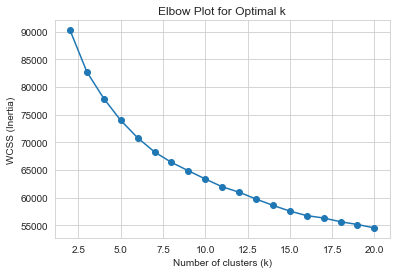

In [242]:
import matplotlib.pyplot as plt

wcss = []
K_range = range(2, 21)  # try 2 through 10 clusters
for k in K_range:
    km = Pipeline(steps=[
        ('preprocess', preprocessor),
        ('kmeans', KMeans(n_clusters=k, random_state=42))
    ])
    km.fit(df_sub)
    wcss.append(km.named_steps['kmeans'].inertia_)

plt.plot(K_range, wcss, marker='o')
plt.xlabel('Number of clusters (k)')
plt.ylabel('WCSS (Inertia)')
plt.title('Elbow Plot for Optimal k')
plt.show()

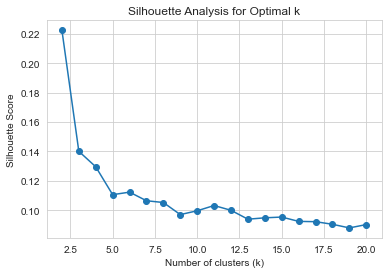

In [243]:
silhouette_scores = []
for k in K_range:
    km = Pipeline(steps=[
        ('preprocess', preprocessor),
        ('kmeans', KMeans(n_clusters=k, random_state=42))
    ])
    labels = km.fit_predict(df_sub)
    score = silhouette_score(
        preprocessor.fit_transform(df_sub),  # transform first
        labels
    )
    silhouette_scores.append(score)

plt.plot(K_range, silhouette_scores, marker='o')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Analysis for Optimal k')
plt.show()


In [245]:
best_k = 6  # suppose the elbow and silhouette both suggest k=6
final_pipeline = Pipeline(steps=[
    ('preprocess', preprocessor),
    ('kmeans', KMeans(n_clusters=best_k, random_state=1))
])

final_pipeline.fit(df_sub)
df_sub['cluster_label'] = final_pipeline.named_steps['kmeans'].labels_

In [246]:
cluster_summary = df_sub.groupby('cluster_label')[num_features].mean()
display(cluster_summary)

,URB,INCOME_final,SOCCL_A,SOCCL_B1,SOCCL_B2,SOCCL_C,SOCCL_D,EDU_HIGH,EDU_MID,EDU_LOW,...,FAM_WCHILD_Y,FAM_WCHILD_MED,FAM_WCHILD_OLD,CIT_HOUSEHOLD,LOAN,SAVINGS,SHOP_ONLINE,CAR,conv,churn
cluster_label,,,,,,,,,,,,,,,,,,,,,
0,4.678609,3.002107,2.140148,3.608008,2.473130,1.339305,1.219178,2.236038,4.053741,2.177028,...,1.480506,2.337197,3.430980,4.429926,2.641728,5.007376,4.923077,4.816649,0.103267,-0.880927
1,3.890000,4.153333,1.143333,1.430000,2.190000,2.466667,3.373333,1.353333,1.983333,4.673333,...,1.243333,1.416667,2.473333,2.470000,1.623333,2.190000,1.630000,2.800000,0.056667,-0.946667
2,2.368807,3.829358,1.044037,1.269725,2.638532,3.211009,2.519266,1.251376,2.737615,4.049541,...,1.418349,1.666055,1.612844,3.271560,3.565138,3.214679,2.333945,1.721101,0.244037,-0.677064
3,2.728027,2.731343,2.132670,2.897181,2.907131,1.529022,1.177446,2.611940,3.822554,1.731343,...,2.076285,2.076285,2.291874,3.258706,3.630182,5.067993,5.474295,3.459370,0.145937,-0.857380
4,3.689441,2.121118,4.403727,2.099379,1.566770,1.161491,1.035714,4.479814,2.190994,1.341615,...,1.433230,2.301242,3.177019,4.722050,2.470497,5.500000,5.593168,4.798137,0.118012,-0.905280
5,4.245902,3.563934,1.154098,1.929508,3.452459,2.234426,2.119672,1.403279,2.598361,4.221311,...,1.357377,1.855738,2.708197,4.209836,3.440984,3.098361,3.214754,3.977049,0.122951,-0.863934


In [247]:
# For each categorical column, count how many rows of each category fall in each cluster
for col in cat_features:
    print(f"\n== {col} Distribution by Cluster ==")
    print(pd.crosstab(df_sub[col], df_sub['cluster_label'], normalize='columns'))


== PROVINCE Distribution by Cluster ==
cluster_label         0         1         2         3         4         5
PROVINCE                                                                 
Drenthe        0.026344  0.023333  0.005505  0.004975  0.012422  0.022951
Flevoland      0.010537  0.013333  0.003670  0.029851  0.024845  0.011475
Friesland      0.021075  0.036667  0.000000  0.006633  0.009317  0.027869
Gelderland     0.252898  0.203333  0.113761  0.190713  0.178571  0.262295
Groningen      0.057956  0.106667  0.040367  0.031509  0.031056  0.101639
Limburg        0.062171  0.010000  0.034862  0.021559  0.012422  0.042623
North Brabant  0.064278  0.116667  0.045872  0.066335  0.135093  0.057377
North Holland  0.064278  0.093333  0.097248  0.135987  0.141304  0.068852
Overijssel     0.185458  0.200000  0.102752  0.107794  0.124224  0.142623
South Holland  0.187566  0.160000  0.416514  0.310116  0.208075  0.181967
Utrecht        0.061117  0.033333  0.135780  0.094527  0.116460  0.07868

In [248]:
# Rebuild the same preprocessor you used for KMeans
cat_transformer = OneHotEncoder(sparse=False, drop='first')
num_transformer = StandardScaler()

preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_transformer, num_features),
        ('cat', cat_transformer, cat_features),
    ]
)

# Fit‐transform the data so we get a pure numeric matrix for PCA
X_preprocessed = preprocessor.fit_transform(df_sub[columns_to_keep_kmeans])

In [250]:
# ─────────────────────────────────────────────────────────
# (C) Run PCA with 10omponents
# ─────────────────────────────────────────────────────────
pca_10 = PCA(n_components=10, random_state=1)
X_pca10 = pca_10.fit_transform(X_preprocessed)

# 1. Print the explained-variance ratio for PC1, PC2, PC3, PC4, etc
print("\nExplained Variance Ratio (10 PCs):")
print(pca_10.explained_variance_ratio_)
# e.g. output might look like [0.15, 0.10, 0.07, 0.05]

# 2. Put those 4 components into a DataFrame
df_pca10 = pd.DataFrame(
    X_pca10,
    columns=['PC1', 'PC2', 'PC3', 'PC4','PC5','PC6','PC7','PC8','PC9','PC10']
)
print("\nFirst five rows of the 4-component PCA result:")
print(df_pca10.head())


Explained Variance Ratio (10 PCs):
[0.32023824 0.09960361 0.08629745 0.07215942 0.04433311 0.03596822
 0.0315452  0.02922548 0.02677491 0.02428191]

First five rows of the 4-component PCA result:
        PC1       PC2       PC3       PC4       PC5       PC6       PC7  \
0 -4.321996  0.425306 -0.780818 -0.251088 -0.298287 -0.293842  1.647365   
1 -2.146164  0.489722 -2.375353 -1.126967 -0.176450 -0.525929 -0.195940   
2 -2.786663 -1.050731 -0.483319  0.482489 -0.895223 -0.724638  1.654416   
3  6.025065  1.200454  1.476924  0.896697 -0.800747  0.687976  0.587156   
4  2.489163 -1.341858 -1.061152 -0.349487  3.210528  1.450763 -0.310129   

        PC8       PC9      PC10  
0 -0.117372  0.684674 -0.271426  
1  1.275592 -0.042315  0.324103  
2 -1.110834  1.869878 -0.933617  
3 -1.278246  0.032765  0.000914  
4  0.157553 -1.249161 -0.273278  


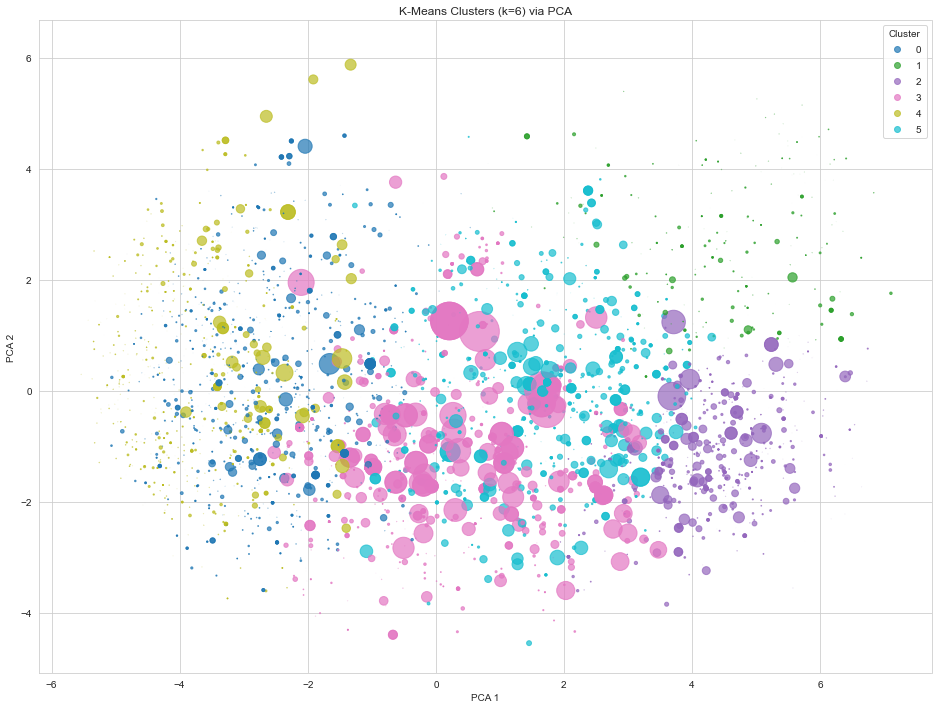

In [258]:
plt.figure(figsize=(16,12))
scatter = plt.scatter(X_pca[:,0], X_pca[:,1],s=X_pca[:,2]**4,
                      c=df_sub['cluster_label'], cmap='tab10', alpha=0.7)
plt.xlabel('PCA 1'); plt.ylabel('PCA 2')
plt.title(f'K-Means Clusters (k={best_k}) via PCA')
plt.legend(*scatter.legend_elements(), title="Cluster")
plt.show()

In [262]:
import pandas as pd
import numpy as np

# ─────────────────────────────────────────────────────────────
# STEP 0: Reconstruct/confirm you have these two objects:
#   1. `preprocessor`  (ColumnTransformer you used before)
#   2. `pca_4`         (PCA instance fitted with n_components=4)
# ─────────────────────────────────────────────────────────────

# Example:
# preprocessor = ColumnTransformer([...])  # as you built earlier
# pca_4 = PCA(n_components=4, random_state=42)
# X_preprocessed = preprocessor.fit_transform(df_sub[columns_to_keep])
# pca_4.fit(X_preprocessed)

# ─────────────────────────────────────────────────────────────
# STEP 1: Extract the “feature names” after preprocessing
# ─────────────────────────────────────────────────────────────

# 1a) Numeric feature names stay as-is:
num_feats = [col for col in columns_to_keep if col not in cat_features]

# 1b) Categorical feature names become one‐hot columns. 
#     Use the fitted OneHotEncoder to get them:
ohe = None
for name, transformer, cols in preprocessor.transformers_:
    if name == 'cat':
        ohe = transformer
        ohe_input_cols = cols
        break

# This line works only if you used OneHotEncoder(sparse=False, drop='first')
cat_ohe_names = list(ohe.get_feature_names_out(ohe_input_cols))

# 1c) Combine numeric + one-hot names into a single list, in the exact order
#     that ColumnTransformer applied them. By default, ColumnTransformer
#     concatenates “num” first, then “cat”:
all_feature_names = num_feats + cat_ohe_names

# ─────────────────────────────────────────────────────────────
# STEP 2: Build a DataFrame of loadings (components)
# ─────────────────────────────────────────────────────────────

# pca_4.components_ is a 4×M array, where M = len(all_feature_names)
# each row = the coefficients for PC_i; each column = one feature

loadings = pd.DataFrame(
    data=pca_4.components_.T,     # transpose so features = rows, PCs = columns
    index=all_feature_names,      # each row is an original (preprocessed) feature
    columns=[f"PC{i+1}" for i in range(pca_4.n_components_)]
)

print("=== Loadings (first 5 rows) ===")
print(loadings.head())


# ─────────────────────────────────────────────────────────────
# STEP 3: For each PC, show the top-and-bottom features by absolute loading
# ─────────────────────────────────────────────────────────────

def top_features_for_pc(pc_number, n=10):
    """
    Return the top‐n features (by absolute loading) for PC index `pc_number` (1‐based).
    """
    pc_label = f"PC{pc_number}"
    # Sort by absolute value descending
    sorted_feats = loadings[pc_label].abs().sort_values(ascending=False)
    tops = sorted_feats.head(n).index.tolist()
    return tops

for i in range(1, pca_4.n_components_ + 1):
    tops = top_features_for_pc(pc_number=i, n=8)
    print(f"\nTop 8 features driving PC{i}:")
    print(loadings.loc[tops, f"PC{i}"].sort_values(ascending=False))


ValueError: Shape of passed values is (43, 10), indices imply (44, 10)